#Library

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd

#Loading Data

This data shows us what kind of emotions people are feeling based on what they type. Like, someone saying "I feel like I'm still staring at a blank canvas, empty sheets of paper" is probably pretty bummed (sadness). [Source](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)

In [ ]:
df = pd.read_csv('/content/EMOTION.txt', sep=';', header=None, names=['sentence', 'emotion'])
df

,sentence,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness
19996,i constantly worry about their fight against n...,joy
19997,i feel its important to share this info for th...,joy
19998,i truly feel that if you are passionate enough...,joy


According to the data source, this data appears to be clean.

#Data Visualization

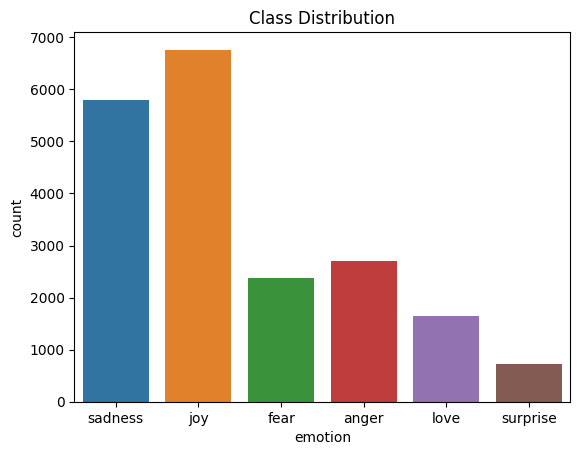

In [ ]:
sns.countplot(x='emotion', data=df)
plt.title('Class Distribution')
plt.show()

The labels in the dataset are not evenly distributed

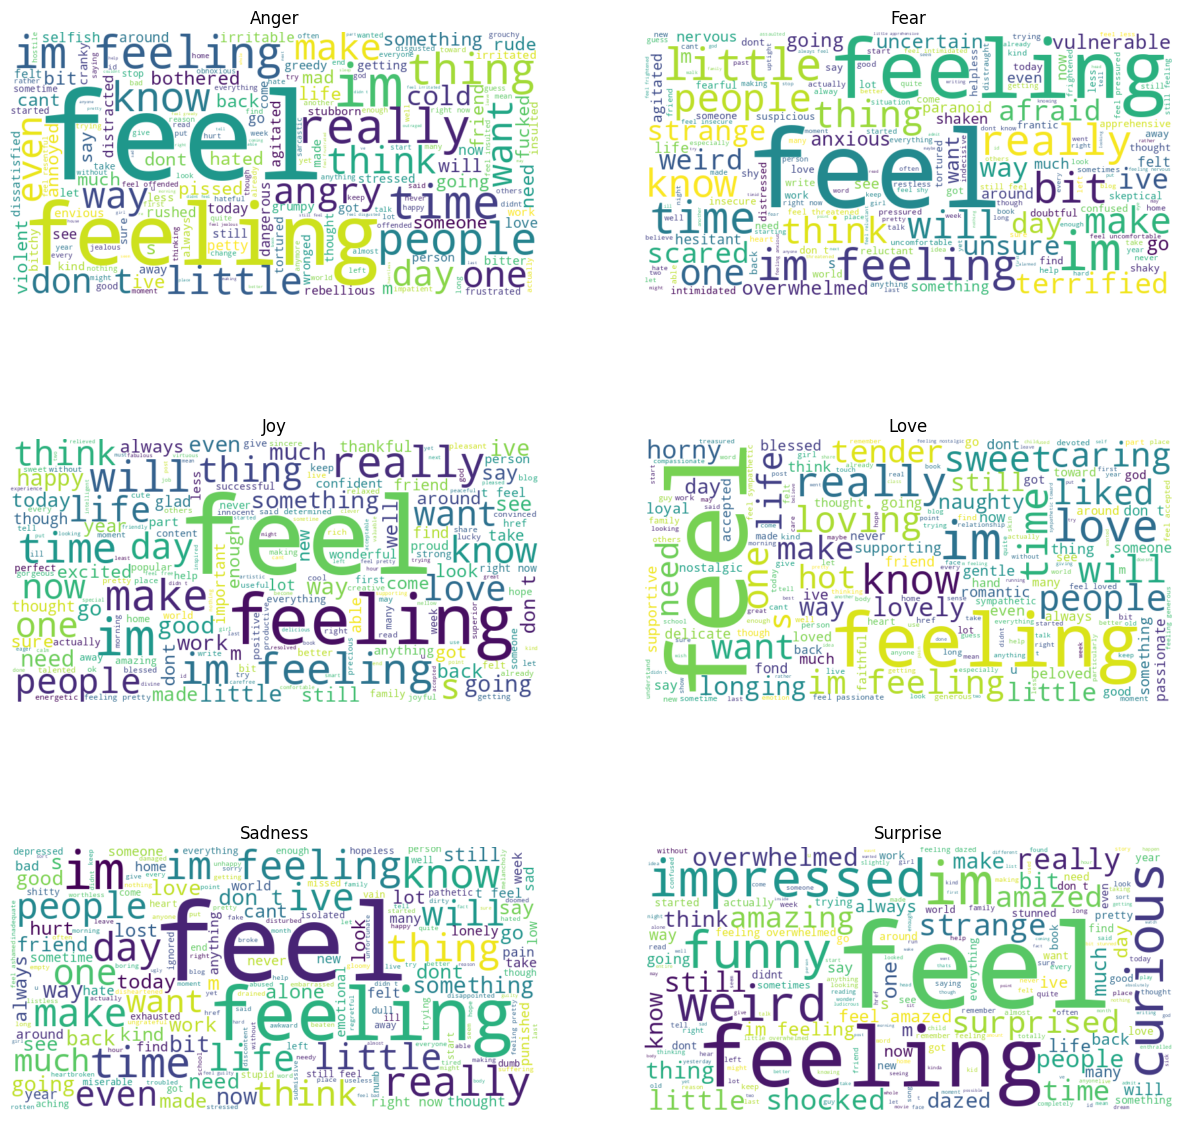

In [ ]:
# Grouping sentences by emotion
grouped_sentences = df.groupby('emotion')['sentence'].apply(lambda x: ' '.join(x))

# Creating a word cloud for each emotion
wordclouds = {}
for emotion, sentences in grouped_sentences.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentences)
    wordclouds[emotion] = wordcloud

# Displaying word clouds
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for ax, (emotion, wordcloud) in zip(axes.flatten(), wordclouds.items()):
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(emotion.capitalize())
    ax.axis('off')


plt.show()

#Data Preprocessing

##One Hot Encoding

In [ ]:
category = pd.get_dummies(df.emotion)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='emotion')
new_df

,sentence,anger,fear,joy,love,sadness,surprise
0,im feeling rather rotten so im not very ambiti...,0,0,0,0,1,0
1,im updating my blog because i feel shitty,0,0,0,0,1,0
2,i never make her separate from me because i do...,0,0,0,0,1,0
3,i left with my bouquet of red and yellow tulip...,0,0,1,0,0,0
4,i was feeling a little vain when i did this one,0,0,0,0,1,0
...,...,...,...,...,...,...,...
19995,im having ssa examination tomorrow in the morn...,0,0,0,0,1,0
19996,i constantly worry about their fight against n...,0,0,1,0,0,0
19997,i feel its important to share this info for th...,0,0,1,0,0,0
19998,i truly feel that if you are passionate enough...,0,0,1,0,0,0


##Splitting Data

To address the issue of class imbalance, I utilize stratified sampling to achieve a balanced representation of labels in the training data and validation data.

In [ ]:
sentence = new_df['sentence'].values
label = new_df[['anger', 'fear', 'joy', 'love', 'sadness','surprise']].values

In [ ]:
df['emotion'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: emotion, dtype: int64

In [ ]:
len(df)

20000

In [ ]:
from sklearn.model_selection import train_test_split
sentence_train, sentence_val, label_train, label_val = train_test_split(sentence, category, test_size=0.2,random_state=1, stratify=label) #Stratify the data because there is imbalance in label

In [ ]:
train_emotions_distribution = pd.DataFrame(label_train, columns=df['emotion'].unique()).sum()
val_emotions_distribution = pd.DataFrame(label_val, columns=df['emotion'].unique()).sum()

train_emotions_distribution, val_emotions_distribution


(sadness     4638
 joy         5409
 fear        1898
 anger       2167
 love        1313
 surprise     575
 dtype: int64,
 sadness     1159
 joy         1352
 fear         475
 anger        542
 love         328
 surprise     144
 dtype: int64)

In [ ]:
len(sentence_train)

16000

In [ ]:
len(sentence_val)

4000

##Text Preprocessing

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(sentence_train)

sequence_train = tokenizer.texts_to_sequences(sentence_train)
sequence_val = tokenizer.texts_to_sequences(sentence_val)



padded_train = pad_sequences(sequence_train,maxlen=50)
padded_val = pad_sequences(sequence_val,maxlen=50)

#Model Building

##Callback

The callback function is used to stop the training process when the accuracy of the training data and validation data is above 90%.

In [ ]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc > 0.90 and val_acc > 0.90:
                print(f"\nReached 90% accuracy for both training and validation. Stopping training at epoch {epoch+1}.")
                self.model.stop_training = True

# Create an instance of the custom callback
custom_callback = CustomCallback()

##Model Architecture

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000,64,input_length=50),
    tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalMaxPooling1D(keepdims=True),

    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])

#Training

In [ ]:
num_epochs = 200
history = model.fit(padded_train, label_train,
                    epochs=num_epochs,
                    batch_size=128,
                    validation_data=(padded_val, label_val),
                    callbacks=[custom_callback]
                    )

Epoch 1/200
125/125 [==============================] - 21s 124ms/step - loss: 1.6402 - accuracy: 0.3159 - val_loss: 1.7224 - val_accuracy: 0.3380
Epoch 2/200
125/125 [==============================] - 7s 51ms/step - loss: 1.6017 - accuracy: 0.3350 - val_loss: 1.6811 - val_accuracy: 0.3390
Epoch 3/200
125/125 [==============================] - 4s 30ms/step - loss: 1.5589 - accuracy: 0.3738 - val_loss: 1.6238 - val_accuracy: 0.3985
Epoch 4/200
125/125 [==============================] - 2s 19ms/step - loss: 1.4004 - accuracy: 0.4781 - val_loss: 1.4574 - val_accuracy: 0.5543
Epoch 5/200
125/125 [==============================] - 2s 19ms/step - loss: 1.0786 - accuracy: 0.6132 - val_loss: 1.0510 - val_accuracy: 0.7325
Epoch 6/200
125/125 [==============================] - 2s 15ms/step - loss: 0.8233 - accuracy: 0.7035 - val_loss: 0.7368 - val_accuracy: 0.7878
Epoch 7/200
125/125 [==============================] - 2s 13ms/step - loss: 0.6766 - accuracy: 0.7686 - val_loss: 0.5646 - val_accurac

#Result

In [ ]:
train_accuracy = model.evaluate(padded_train, label_train, verbose=0)[1]
val_accuracy = model.evaluate(padded_val, label_val, verbose=0)[1]

print(f"Train Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")


Train Accuracy: 0.9571874737739563
Validation Accuracy: 0.9035000205039978


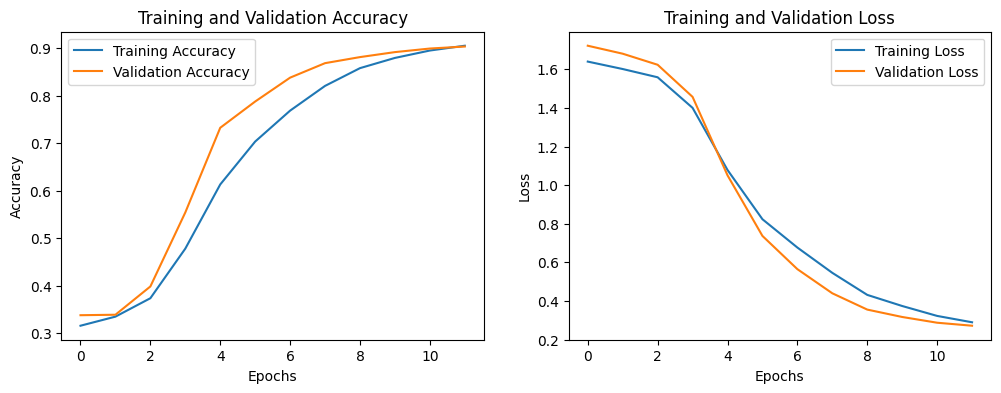

In [ ]:
# Akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
